In [1]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')
import rpy2
%load_ext rpy2.ipython
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import utils
mpl.rcParams['pdf.fonttype'] = 42

## Analyze mutation rarity

This jupyter notebook examines the spectrum of driver frequency in cancer. Specifically, we will analyze driver mutations that are rare (<1 percent of cancer samples), intermediate (1-5), and common (>5).

### CHASMplus

Analyze the rarity of mutations found significant by CHASMplus.

In [2]:
rare_count_df = utils.read_all_rarity_count()
mut_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.maf')
num_samps = mut_df.groupby('CODE')['Tumor_Sample_Barcode'].nunique()
mut_per_sample = rare_count_df.div(num_samps)

In [12]:
# read in information about the rarity of drivers
rare_df = utils.read_all_rarity_results(base_dir='CHASMplus/data/rarity_analysis/')

Next, we plot the fraction of driver mutations in each category.

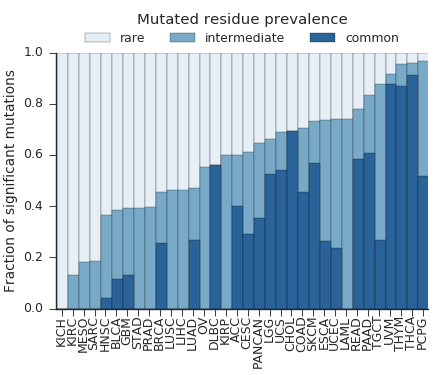

In [14]:
intermediate = rare_df.loc[['common', 'intermediate'],:].sum().sort_values()
common = rare_df.loc['common',:]
blue_pal = sns.color_palette("Blues", 9)
with mpl.style.context('classic'):
    with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
        sns.barplot(intermediate.index, [1]*len(common), color=blue_pal[0], label='rare')
        sns.barplot(intermediate.index, intermediate[intermediate.index], color=blue_pal[4], label='intermediate')
        sns.barplot(intermediate.index, common[intermediate.index], color=blue_pal[7], label='common')
        sns.despine()
        myleg = plt.legend(loc='upper center', title='Mutated residue prevalence', bbox_to_anchor=(.5, 1.2), ncol=3)
        plt.ylabel('Fraction of significant mutations')
        plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='center')
        plt.gca().tick_params(axis='x', which='major', pad=0)
        #plt.gca().set_ylim((0, 90))

        # max barwidths fill the complete width
        myax = plt.gca()
        for bar in myax.patches:
            bar.set_width(1)

        # save figure
        plt.gcf().set_size_inches(6, 4)
        plt.savefig('CHASMplus/figures/figure_3a.pdf', bbox_inches='tight', bbox_extra_artists=[myleg])

### Hotspots (Chang et al.)

For comparison we performed a pan-cancer analysis with the hotspots method by Chang et al.

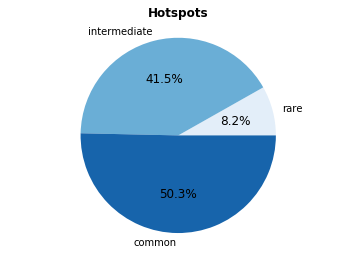

In [15]:
rare_chang_df = pd.read_table('CHASMplus/data/misc/rarity_chang_et_al_pancan.txt')
chang_counts = rare_chang_df.groupby('category')['number of mutations'].sum()
with sns.plotting_context('paper', font_scale=1.25):
    pie_colors = [blue_pal[0], blue_pal[4], blue_pal[7]]
    labels = ['rare', 'intermediate', 'common']
    plt.pie(chang_counts[labels], colors=pie_colors, labels=labels, autopct='%.1f%%')
    plt.title('Hotspots', fontdict={'verticalalignment': 'bottom', 'fontweight': 'bold'})
    _ = plt.axis('equal')

#### Comparison between CHASMplus and Hotspots

First, we compare the proportion of rare driver mutations in CHASMplus to that of the Hotspot method.

In [16]:
rare_chasmplus_df = pd.read_table('CHASMplus/data/rarity_analysis/PANCAN.txt')
chasmplus_counts = rare_chasmplus_df.groupby('category')['number of mutations'].sum()

# compare using a fisher exact test
chasmplus_nonrare = chasmplus_counts.loc[['common', 'intermediate']].sum()
chasmplus_rare = chasmplus_counts.loc['rare']
chang_nonrare = chang_counts.loc[['common', 'intermediate']].sum()
chang_rare = chang_counts.loc['rare']
contigency_table = np.array([[chasmplus_rare, chang_rare], [chasmplus_nonrare, chang_nonrare]])

Using a fisher exact test, we find CHASMplus finds significantly more rare drivers than the Hotspot method.

In [17]:
%%R -i contigency_table
fisher.test(contigency_table)


	Fisher's Exact Test for Count Data

data:  contigency_table
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 5.618475 6.794491
sample estimates:
odds ratio 
  6.174854 



Next, we look at the comparison of the codons called significant by the Hotspot method to those found by CHASMplus.

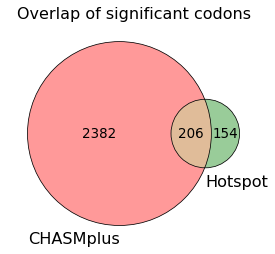

In [18]:
from matplotlib_venn import venn2, venn2_circles

# read in data
pancan_df = utils.read_result('PANCAN', only_significant=True)

# overlap the two
chasm2_pos = list((pancan_df['Hugo_Symbol'] + '_' + pancan_df['Protein_position_x'].astype(str)).unique())
chang_pos = list(rare_chang_df.mutation.unique())
len_intersect = len(set(chasm2_pos) & set(chang_pos))
len_chasm2 = len(chasm2_pos)
len_chang = len(chang_pos)
overlap = (len_chasm2 - len_intersect, len_chang - len_intersect, len_intersect)

# plot venn diagram
with sns.plotting_context('paper', font_scale=1.4):
    venn2(subsets=overlap, set_labels=('CHASMplus', 'Hotspot'))
    venn2_circles(subsets=overlap, linestyle='solid', linewidth=.75)
    plt.title('Overlap of significant codons', size=16)

### Correlation of mutation burden with driver prevalence

Next, we will look at whether the prevalence of driver mutations is correlated with the mutation burden for the same cancer type.

In [19]:
# get the count of rare vs common drivers
counts_by_type = utils.read_all_rarity_count(base_dir='CHASMplus/data/rarity_analysis/')

# calculate mutation burden
mut_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.maf')
mut_burden_by_sample = mut_df.groupby(['CODE', 'Tumor_Sample_Barcode']).size()
num_samps = mut_df.groupby(['CODE'])['Tumor_Sample_Barcode'].nunique()
mut_burden_median = mut_burden_by_sample.median(level=0)

In [20]:
# prepare dataframe for the purpose of plotting
rare_prev = counts_by_type.loc['rare'] / num_samps
intermediate_prev = counts_by_type.loc['intermediate'] / num_samps
common_prev = counts_by_type.loc['common'] / num_samps
plot_df = pd.DataFrame({'rare prevalence': rare_prev,
                        'intermediate prevalence': intermediate_prev,
                        'common prevalence': common_prev,
                        'mutation burden': mut_burden_median, 
                        'sample size': num_samps}).dropna()

#### Rare drivers

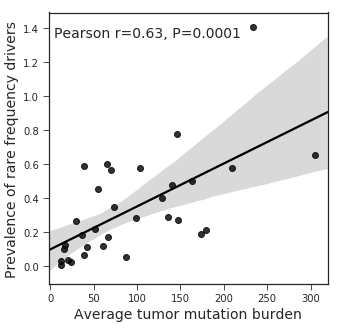

In [21]:
with sns.axes_style('ticks'):
    reg = stats.linregress(plot_df['mutation burden'], plot_df['rare prevalence'])
    sns.regplot('mutation burden', 'rare prevalence', 
                data=plot_df, color='black')
    plt.text(5, 1.35, 'Pearson r={0:.2f}, P={1:.4f}'.format(reg.rvalue, reg.pvalue), size=14)
    plt.ylabel('Prevalence of rare frequency drivers', size=14)
    plt.xlabel('Average tumor mutation burden', size=14)
    fig = plt.gcf()
    fig.set_size_inches(5,5)
    plt.savefig('CHASMplus/figures/figure_3b_rare.pdf')

#### Intermediate drivers

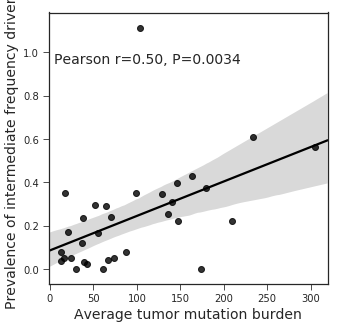

In [22]:
with sns.axes_style('ticks'):
    reg = stats.linregress(plot_df['mutation burden'], plot_df['intermediate prevalence'])
    sns.regplot('mutation burden', 'intermediate prevalence', 
                data=plot_df, color='black')
    plt.text(5, .95, 'Pearson r={0:.2f}, P={1:.4f}'.format(reg.rvalue, reg.pvalue), size=14)
    plt.ylabel('Prevalence of intermediate frequency drivers', size=14)
    plt.xlabel('Average tumor mutation burden', size=14)
    fig = plt.gcf()
    fig.set_size_inches(5,5)
    plt.savefig('CHASMplus/figures/figure_3b_intermediate.pdf')

#### Common drivers

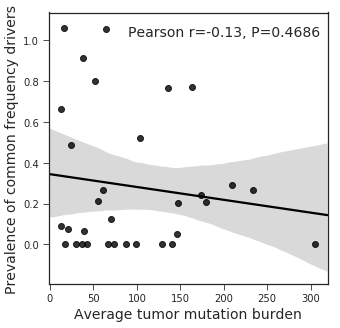

In [23]:
with sns.axes_style('ticks'):
    reg = stats.linregress(plot_df['mutation burden'], plot_df['common prevalence'])
    sns.regplot('mutation burden', 'common prevalence', 
                data=plot_df, color='black')
    plt.text(90, 1.02, 'Pearson r={0:.2f}, P={1:.4f}'.format(reg.rvalue, reg.pvalue), size=14)
    plt.ylabel('Prevalence of common frequency drivers', size=14)
    plt.xlabel('Average tumor mutation burden', size=14)
    fig = plt.gcf()
    fig.set_size_inches(5,5)
    plt.savefig('CHASMplus/figures/figure_3b_common.pdf')

#### Statistical test

Although rare driver prevalence seems to be correlated with mutation burden for a cancer type, the sample size of each cancer type could be a confounder. We next performed a liklihood ratio test to control for sample size.

In [24]:
%%R -i plot_df
lm1 <- lm(common.prevalence~mutation.burden+sample.size, plot_df)
lm0 <- lm(common.prevalence~sample.size, plot_df)
anova(lm0, lm1, test="Chisq")

Analysis of Variance Table

Model 1: common.prevalence ~ sample.size
Model 2: common.prevalence ~ mutation.burden + sample.size
  Res.Df    RSS Df Sum of Sq Pr(>Chi)
1     30 3.6045                      
2     29 3.5687  1  0.035815   0.5896
